# Data Management Project: Bitcoin sentiment analysis

### Data sources:
- Bitcoin Volume: API endpoint -> https://api.binance.com/api/v3/klines
- NyTimes news: API endpoint -> https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey

(Limit NYtimes: Yes, there are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.)

Important: 
- create in your environment a .env file
- write: NY_KEY = "your_key"
- use the command load_dotenv()
- key = os.getenv("NY_KEY")

In [26]:
!pip install python-dotenv


[notice] A new release of pip available: 22.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
!pip install kafka-python pymongo

     -------------------------------------- 859.2/859.2 kB 4.5 MB/s eta 0:00:00
     -------------------------------------- 331.1/331.1 kB 6.8 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install tqdm

     ---------------------------------------- 78.5/78.5 kB 2.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
import json
from datetime import datetime, date, timedelta
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

from kafka import KafkaProducer
from kafka import KafkaConsumer

from pymongo import MongoClient

load_dotenv()

True

### BitCoin:

In [9]:
url = "https://api.binance.com/api/v3/klines"
params = {
    "symbol": "BTCUSDT",
    "interval": "1d",
    "limit": 10000
}

response = requests.get(url, params=params)
data = response.json()

# Converte le candele in un formato leggibile
candles = []
for c in data:
    open_time = datetime.fromtimestamp(c[0]/1000)   # converte ms → datetime
    open_price = float(c[1])
    high = float(c[2])
    low = float(c[3])
    close_price = float(c[4])

    candles.append({
        "date": open_time.strftime("%Y-%m-%d"),
        "open": open_price,
        "high": high,
        "low": low,
        "close": close_price
    })

for c in candles:
    print(c)


{'date': '2023-03-15', 'open': 24670.41, 'high': 25196.97, 'low': 23896.95, 'close': 24285.66}
{'date': '2023-03-16', 'open': 24285.66, 'high': 25167.4, 'low': 24123.0, 'close': 24998.78}
{'date': '2023-03-17', 'open': 24998.78, 'high': 27756.84, 'low': 24890.0, 'close': 27395.13}
{'date': '2023-03-18', 'open': 27395.13, 'high': 27724.85, 'low': 26578.0, 'close': 26907.49}
{'date': '2023-03-19', 'open': 26907.49, 'high': 28390.1, 'low': 26827.22, 'close': 27972.87}
{'date': '2023-03-20', 'open': 27972.87, 'high': 28472.0, 'low': 27124.47, 'close': 27717.01}
{'date': '2023-03-21', 'open': 27717.01, 'high': 28438.55, 'low': 27303.1, 'close': 28105.47}
{'date': '2023-03-22', 'open': 28107.81, 'high': 28868.05, 'low': 26601.8, 'close': 27250.97}
{'date': '2023-03-23', 'open': 27250.97, 'high': 28750.0, 'low': 27105.0, 'close': 28295.41}
{'date': '2023-03-24', 'open': 28295.42, 'high': 28374.3, 'low': 27000.0, 'close': 27454.47}
{'date': '2023-03-25', 'open': 27454.46, 'high': 27787.33, 'lo

In [3]:
import yfinance as yf

# yfinance aggira i blocchi perché simula un browser che visita il sito
# Non ha limiti "hard" sugli anni passati
btc = yf.download(["BTC-USD","ETH-USD"], start="2021-01-01", end="2025-12-08")

C:\Users\tomma\AppData\Local\Temp\ipykernel_15556\3098547809.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download(["BTC-USD","ETH-USD"], start="2021-01-01", end="2025-12-08")
[*********************100%***********************]  2 of 2 completed


In [4]:
df = pd.DataFrame(btc) # Convert into DataFrame
print(df.columns)
df.head()

MultiIndex([( 'Close', 'BTC-USD'),
            ( 'Close', 'ETH-USD'),
            (  'High', 'BTC-USD'),
            (  'High', 'ETH-USD'),
            (   'Low', 'BTC-USD'),
            (   'Low', 'ETH-USD'),
            (  'Open', 'BTC-USD'),
            (  'Open', 'ETH-USD'),
            ('Volume', 'BTC-USD'),
            ('Volume', 'ETH-USD')],
           names=['Price', 'Ticker'])


Price              Close                       High               \
Ticker           BTC-USD      ETH-USD       BTC-USD      ETH-USD   
Date                                                               
2021-01-01  29374.152344   730.367554  29600.626953   749.201843   
2021-01-02  32127.267578   774.534973  33155.117188   786.798462   
2021-01-03  32782.023438   975.507690  34608.558594  1006.565002   
2021-01-04  31971.914062  1040.233032  33440.218750  1153.189209   
2021-01-05  33992.429688  1100.006104  34437.589844  1129.371460   

Price                Low                      Open                    Volume  \
Ticker           BTC-USD     ETH-USD       BTC-USD      ETH-USD      BTC-USD   
Date                                                                           
2021-01-01  28803.585938  719.792236  28994.009766   737.708374  40730301359   
2021-01-02  29091.181641  718.109497  29376.455078   730.402649  67865420765   
2021-01-03  32052.316406  771.561646  32129.408203   774.511841  78665235202   
2021-01-04  28722.755859  912.305359  32810.949219   977.058838  81163475344   
2021-01-05  30221.187500  986.811279  31977.041016  1041.498779  67547324782   

Price                    
Ticker          ETH-USD  
Date                     
2021-01-01  13652004358  
2021-01-02  19740771179  
2021-01-03  45200463368  
2021-01-04  56945985763  
2021-01-05  41535932781

In [5]:
df.isna().sum() # There is no Missing Values

Price   Ticker 
Close   BTC-USD    0
        ETH-USD    0
High    BTC-USD    0
        ETH-USD    0
Low     BTC-USD    0
        ETH-USD    0
Open    BTC-USD    0
        ETH-USD    0
Volume  BTC-USD    0
        ETH-USD    0
dtype: int64

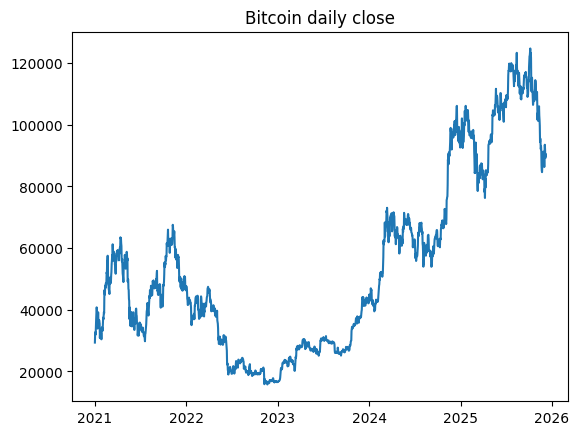

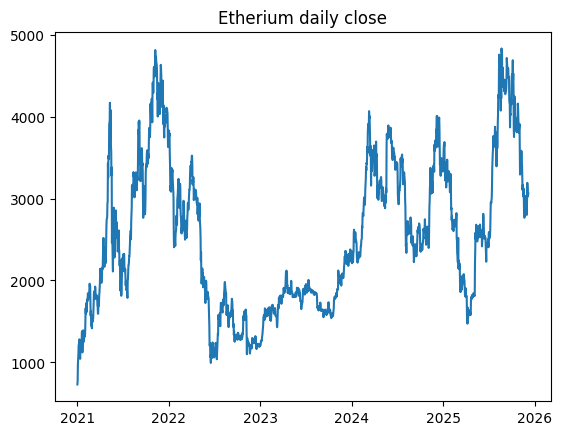

In [7]:
plt.figure()
plt.plot(df.index,df['Close']['BTC-USD'])
plt.title("Bitcoin daily close")
plt.show()
plt.figure()
plt.plot(df.index,df['Close']['ETH-USD'])
plt.title("Etherium daily close")
plt.show()

### NyTimes article:

In [10]:

key = os.getenv("NY_KEY") # your api key
query = 'Bitcoin'
i = 0
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

In [17]:
nyresponse = requests.get(url).json()
nyresponse

{'status': 'OK',
 'copyright': 'Copyright (c) 2025 The New York Times Company. All Rights Reserved.',
 'response': {'docs': [{'abstract': 'Bitcoin has plunged more than 30 percent and Ether is down around 40 percent in recent months, as gains from President Trump’s pro-crypto policies evaporated.',
    'byline': {'original': 'By David Yaffe-Bellany and Kailyn Rhone'},
    'document_type': 'article',
    'headline': {'main': 'Those Sky-High Bitcoin Prices Everyone Said Were Here to Stay? They Left.',
     'kicker': '',
     'print_headline': 'Those Sky-High Prices Forecast for Bitcoin? They Didn’t Pan Out.'},
    '_id': 'nyt://article/8e021b81-4ea1-5475-b807-1ae1c42219b5',
    'keywords': [{'name': 'Subject', 'value': 'Virtual Currency', 'rank': 1},
     {'name': 'Subject',
      'value': 'United States Politics and Government',
      'rank': 2},
     {'name': 'Subject', 'value': 'Bitcoin (Currency)', 'rank': 3},
     {'name': 'Subject',
      'value': 'Regulation and Deregulation of In

In [18]:
len(nyresponse["response"]["docs"])

10

In [19]:
i = 1
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

In [19]:
nyresponse = requests.get(url).json()

nyresponse

with open("nytimes.json", "w", encoding="utf-8") as f:
    json.dump(nyresponse, f, ensure_ascii=False, indent=4)

In [11]:
key = os.getenv("NY_KEY")
query = 'crypto'
i = 0
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

nyresponse = requests.get(url).json()

nyresponse

{'fault': {'faultstring': 'Invalid ApiKey',
  'detail': {'errorcode': 'oauth.v2.InvalidApiKey'}}}

In [3]:
# Definition of the Kafka Producer:

producer = KafkaProducer(
    bootstrap_servers="localhost:9092",
    value_serializer=lambda v: json.dumps(v).encode("utf-8")
)



1. **Data retrieval from the New York Times API**  
   - Uses the API key stored in the environment variable `NY_KEY`.  
   - Searches for the queries `"Bitcoin"` and `"Crypto"`.  
   - Iterates through 100 pages of results for each query.

2. **Request and error handling**  
   - Each HTTP request is executed using `requests.get`.  
   - The response status is checked with `raise_for_status()` to catch any HTTP errors.  
   - In case of an error (e.g., `429 Too Many Requests`, timeout, connection issues), the error is logged and the loop continues with the next request.

3. **Sending data to Kafka**  
   - If the response is valid, the JSON data is sent to a Kafka topic corresponding to the query (`Bitcoin` or `Crypto`).  
   - This allows real-time processing or storage of the data via a Kafka consumer.

4. **Rate limit management**  
   - After each request, the script waits 15 seconds (`time.sleep(15)`) to avoid exceeding NYT API limits, reducing the risk of `429 Too Many Requests` errors.

**Note:** The script is designed to safely scrape data while respecting the NYT API's per-minute and daily limits, sending the collected data to Kafka for further processing.


In [54]:
key = os.getenv("NY_KEY") # your key
query = ["Bitcoin", "Crypto"] # search for Bitcoin and Crypto in general
for i in range(100): # Set 100 pages
    for q in query: # one call for each query
        url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}' # update url 

        try:
            response = requests.get(url)
            response.raise_for_status()  # raise error for non-200 responses
            
            data = response.json()

            TOPIC = q

            # send only if the response is valid
            producer.send(TOPIC, data)
            print(f"Send result for '{q}', page {i}")

        except Exception as e: 
            print(f"Error in ='{q}', page={i}: {e}")
            continue  # skip

        time.sleep(15)



        

Send result for 'Bitcoin', page 0
Send result for 'Crypto', page 0
Send result for 'Bitcoin', page 1
Send result for 'Crypto', page 1
Send result for 'Bitcoin', page 2
Send result for 'Crypto', page 2
Send result for 'Bitcoin', page 3
Send result for 'Crypto', page 3
Send result for 'Bitcoin', page 4
Send result for 'Crypto', page 4
Send result for 'Bitcoin', page 5
Send result for 'Crypto', page 5
Send result for 'Bitcoin', page 6
Send result for 'Crypto', page 6
Send result for 'Bitcoin', page 7
Send result for 'Crypto', page 7
Send result for 'Bitcoin', page 8
Send result for 'Crypto', page 8
Send result for 'Bitcoin', page 9
Send result for 'Crypto', page 9
Send result for 'Bitcoin', page 10
Send result for 'Crypto', page 10
Send result for 'Bitcoin', page 11
Send result for 'Crypto', page 11
Send result for 'Bitcoin', page 12
Send result for 'Crypto', page 12
Send result for 'Bitcoin', page 13
Send result for 'Crypto', page 13
Send result for 'Bitcoin', page 14
Send result for 'Cr

In [ ]:
# Prova 2:

# Configura il producer (assicurati di avere il serializer JSON)
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

key = os.getenv("NY_KEY")
queries = ["Bitcoin", "Crypto"] # Ho rinominato in plurale per chiarezza

print("Inizio scaricamento...")

for i in tqdm(range(100), desc = "Sending Data"): # Per 100 pagine
    for q in queries: # Per ogni parola chiave
        time.sleep(15)
        
        # CORREZIONE 1: Usiamo {q} (la singola parola) e non {query} (la lista intera)
        url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&page={i}&api-key={key}'
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            
            data = response.json()
            
            # Estraiamo la lista degli articoli dalla risposta grezza
            articles = data.get('response', {}).get('docs', [])
            
            if not articles:
                print(f"Nessun articolo trovato per '{q}' a pagina {i}")
                continue

            # CORREZIONE 2: Inviamo UN messaggio per OGNI articolo (non tutta la pagina)
            for article in articles:
                
                # Creiamo un dizionario pulito (solo ciò che ti serve)
                clean_doc = {
                    'remote_id': article.get('_id'), # ID univoco del NYT
                    'web_url': article.get('web_url'),
                    'pub_date': article.get('pub_date'),
                    'abstract': article.get('abstract'),
                    'lead_paragraph': article.get('lead_paragraph'),
                    'title': article.get('headline', {}).get('main'),
                    'word_count': article.get('word_count'),
                    'source_query': q # Importante: ci salviamo da quale ricerca arriva!
                }
                
                # Inviamo al topic corrispondente
                # (Puoi usare un topic unico 'articles-topic' o mantenerli separati come fai tu)
                TOPIC = q 
                producer.send(TOPIC, clean_doc)
            
            # Flush per assicurarsi che i messaggi partano subito
            producer.flush() 
            print(f"Inviati {len(articles)} articoli puliti per '{q}', pagina {i}")

        except Exception as e: 
            print(f"Errore in '{q}', pagina={i}: {e}")
            continue

        # Rispetta i limiti dell'API (il NYT è severo, 15 sec va bene)
        

Inizio scaricamento...


Sending Data:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

# Imposta il periodo storico
start_date = date(2018, 1, 1)
end_date = date(2024, 12, 31)
current_date = start_date

DAILY_LIMIT = 490
calls_made = 0

key = os.getenv("NY_KEY")
queries = ["Bitcoin", "Crypto", "Ethereum"]

while current_date < end_date:
    next_month = current_date + relativedelta(months=1)
    
    # Formatta le date per l'API NYT (YYYYMMDD)
    begin_str = current_date.strftime("%Y%m%d")
    end_str = next_month.strftime("%Y%m%d")
    
    print(f"\n--- Analisi periodo: {begin_str} - {end_str} ---")
    
    # MODIFICA 1: Iteriamo prima per Query, poi per Pagine.
    # Questo ci permette di interrompere la paginazione per una query specifica appena finiscono i dati.
    for q in queries:
        print(f"Scaricando articoli per: {q}...")
        
        for page in range(100): # Massimo 100 pagine
            if calls_made >= DAILY_LIMIT:
                print(f"RAGGIUNTO IL LIMITE GIORNALIERO ({calls_made}). Mi fermo.")
                print(f"Ultimo periodo elaborato: {begin_str} - {end_str}, Query: {q}, Pagina: {page}")
                exit()
            try:
                # MODIFICA 2: Corretto q={q} nell'URL (prima era fisso su Bitcoin)
                url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&begin_date={begin_str}&end_date={end_str}&page={page}&api-key={key}"
                
                response = requests.get(url)
                response.raise_for_status() # Solleva errore se status != 200

                data = response.json()
                articles = data.get('response', {}).get('docs', [])

                # MODIFICA 3: Se non ci sono articoli, interrompiamo il ciclo delle pagine per QUESTA query
                if not articles:
                    print(f"  -> Nessun altro articolo per '{q}' a pagina {page}. Passo alla prossima query.")
                    break 

                # Invio messaggi a Kafka
                for article in articles:
                    clean_doc = {
                        'remote_id': article.get('_id'),
                        'web_url': article.get('web_url'),
                        'pub_date': article.get('pub_date'),
                        'abstract': article.get('abstract'),
                        'lead_paragraph': article.get('lead_paragraph'),
                        'title': article.get('headline', {}).get('main'),
                        'word_count': article.get('word_count'),
                        'source_query': q
                    }
                    
                    producer.send(q, clean_doc) # Usa 'q' come nome del topic (o usa un topic unico)
            
                producer.flush()
                print(f"  -> Inviati {len(articles)} articoli per '{q}' (Pagina {page})")
                
                # Rispetta il rate limit (12 secondi sono prudenziali e sicuri)
                time.sleep(12)
                calls_made += 1

            except Exception as e:
                print(f"  -> Errore con '{q}' a pagina {page}: {e}")
                # Opzionale: se l'errore è grave (es. 429 Too Many Requests), potresti voler fare un break anche qui
                # break 
                time.sleep(12) # Attesa anche in caso di errore per sicurezza
                continue

    # Passa al mese successivo solo dopo aver finito tutte le query per il mese corrente
    current_date = next_month


--- Analisi periodo: 20180101 - 20180201 ---
Scaricando articoli per: Bitcoin...
  -> Inviati 10 articoli per 'Bitcoin' (Pagina 0)
  -> Inviati 10 articoli per 'Bitcoin' (Pagina 1)
  -> Inviati 10 articoli per 'Bitcoin' (Pagina 2)
  -> Inviati 10 articoli per 'Bitcoin' (Pagina 3)
  -> Inviati 10 articoli per 'Bitcoin' (Pagina 4)
  -> Inviati 10 articoli per 'Bitcoin' (Pagina 5)
  -> Inviati 10 articoli per 'Bitcoin' (Pagina 6)
  -> Inviati 3 articoli per 'Bitcoin' (Pagina 7)
  -> Nessun altro articolo per 'Bitcoin' a pagina 8. Passo alla prossima query.
Scaricando articoli per: Crypto...
  -> Inviati 10 articoli per 'Crypto' (Pagina 0)
  -> Errore con 'Crypto' a pagina 1: 429 Client Error: Too Many Requests for url: https://api.nytimes.com/svc/search/v2/articlesearch.json?q=Crypto&begin_date=20180101&end_date=20180201&page=1&api-key=JVaQ4LJivw2ZTYWJOyv0Md5Ydd9jGeWP
  -> Nessun altro articolo per 'Crypto' a pagina 2. Passo alla prossima query.
Scaricando articoli per: Etherium...
  -> 

KeyboardInterrupt: 

1. **Kafka Consumers Setup**  
   - Two separate consumers are created:
     - `consumer_bitcoin` subscribes to the `"Bitcoin"` topic.
     - `consumer_crypto` subscribes to the `"Crypto"` topic.
   - Both consumers:
     - Connect to the Kafka broker at `localhost:9092`.
     - Deserialize messages from JSON using `json.loads`.
     - Start reading from the earliest available message (`auto_offset_reset="earliest"`) to process past messages.
     - Use a new consumer group `"debug-group"` to avoid committing offsets from previous runs.

2. **MongoDB Setup**  
   - Connects to a local MongoDB instance (`mongodb://localhost:27017`).
   - Uses the database `bitcoin_pr`.
   - Stores articles in the collection `Article`.

3. **Message Consumption and Storage**  
   - For each message received from the `"Bitcoin"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Bitcoin"`.
     - Inserts the document into the MongoDB collection.
   - For each message received from the `"Crypto"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Crypto"`.
     - Inserts the document into MongoDB.

4. **Notes**
   - Using `auto_offset_reset="earliest"` allows the consumer to read **all previous messages** in the topic, which is useful for debugging or reprocessing data.
   - Each consumer runs in a blocking loop, continuously waiting for new messages.
   - Ensure MongoDB is running locally before executing the script.



In [ ]:
consumer_bitcoin = KafkaConsumer(
    "Bitcoin",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group",          # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)

consumer_crypto = KafkaConsumer(
    "Crypto",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group-crypto",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)

consumer_eth = KafkaConsumer(
    "Ethereum",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group-crypto",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)



In [13]:
client = MongoClient("mongodb://localhost:27017")

db = client['bitcoin_project_month']

collection = db['Article']

print("Waiting for Ethereum messages...")
for msg in consumer_eth:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Ethereum'
    collection.insert_one(doc)

print("Waiting for Bitcoin messages...")
for msg in consumer_bitcoin:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Bitcoin'
    collection.insert_one(doc)

print("Waiting for Crypto messages...")
for msg in consumer_crypto:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Crypto'
    collection.insert_one(doc)

print("All messages consumed.")


Waiting for Etherium messages...
Received: {'remote_id': 'nyt://article/54ad3732-2329-5bb3-bb44-3dfea397d8ac', 'web_url': 'https://www.nytimes.com/2018/01/05/your-money/bitcoin-investing.html', 'pub_date': '2018-01-05T16:54:50Z', 'abstract': 'Before chasing Bitcoin or some other shiny thing, ask yourself this first: What are my financial goals? And does speculating fit within those goals?', 'lead_paragraph': None, 'title': 'Should You Buy Bitcoin? Ask a Different Question First', 'word_count': 643, 'source_query': 'Etherium'}
Waiting for Bitcoin messages...
Waiting for Crypto messages...
All messages consumed.


In [43]:
client = MongoClient("mongodb://localhost:27017")

db = client['bitcoin_project']

collection = db['Article']


In [24]:
pipeline = [
    {
        "$group": {
            "_id": "$web_url",  # Sostituisci con il campo che identifica l'univocità (es. id, url, title)
            "count": {"$sum": 1},
            "docs": {"$push": "$_id"} # Opzionale: salva gli ID di Mongo dei duplicati
        }
    },
    {
        "$match": {
            "count": {"$gt": 1} # Filtra solo quelli che compaiono più di una volta
        }
    }
]

duplicati = list(collection.aggregate(pipeline))

print(f"Trovati {len(duplicati)} articoli duplicati.")

for d in duplicati[:5]: # Stampa i primi 5 esempi
    print(f"L'URL {d['_id']} appare {d['count']} volte.")

Trovati 1404 articoli duplicati.
L'URL https://www.nytimes.com/2023/10/03/business/sam-bankman-fried-trial-ftx.html appare 2 volte.
L'URL https://www.nytimes.com/2021/12/23/movies/dead-mans-switch-a-crypto-mystery-review.html appare 2 volte.
L'URL https://www.nytimes.com/live/2023/10/26/business/sam-bankman-fried-ftx-trial/crypto-influencers-and-obsessives-have-flocked-to-the-trial appare 2 volte.
L'URL https://www.nytimes.com/2025/04/07/business/dealbook/trump-tariffs-off-ramp.html appare 2 volte.
L'URL https://www.nytimes.com/2024/10/25/opinion/nebraska-senate-dan-osborn.html appare 3 volte.


In [28]:
# DEDUPLICATION:

duplicati = list(collection.aggregate(pipeline))
print(f"Trovati {len(duplicati)} URL con duplicati.")

# Lista per accumulare tutti gli _id da cancellare
ids_da_cancellare = []

for d in duplicati:
    # d['docs'] è una lista di tutti gli _id che hanno lo stesso URL.
    # d['docs'][0] è quello che SALVIAMO (il primo).
    # d['docs'][1:] sono quelli che ELIMINIAMO (dal secondo in poi).
    ids_da_cancellare.extend(d['docs'][1:])

# Verifica di sicurezza
if ids_da_cancellare:
    print(f"Sto per eliminare {len(ids_da_cancellare)} documenti duplicati...")
    
    # Esegui l'eliminazione in una sola operazione (molto più veloce di un loop)
    risultato = collection.delete_many({"_id": {"$in": ids_da_cancellare}})
    
    print(f"Operazione completata. Eliminati {risultato.deleted_count} documenti.")
else:
    print("Nessun duplicato da eliminare.")

Trovati 0 URL con duplicati.
Nessun duplicato da eliminare.


In [26]:
pipeline = [
    {
        "$group": {
            "_id": "$web_url",  # Sostituisci con il campo che identifica l'univocità (es. id, url, title)
            "count": {"$sum": 1},
            "docs": {"$push": "$_id"} # Opzionale: salva gli ID di Mongo dei duplicati
        }
    },
    {
        "$match": {
            "count": {"$gt": 1} # Filtra solo quelli che compaiono più di una volta
        }
    }
]

duplicati = list(collection.aggregate(pipeline))

print(f"Trovati {len(duplicati)} articoli duplicati.")

for d in duplicati[:5]: # Stampa i primi 5 esempi
    print(f"L'URL {d['_id']} appare {d['count']} volte.")

Trovati 0 articoli duplicati.


In [44]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")
# Conta articoli per query specifica
num_bitcoin = collection.count_documents({'query': 'Bitcoin'})
num_crypto = collection.count_documents({'query': 'Crypto'})

print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")



Number of articles in the collection: 1701
Number of Bitcoin articles: 972
Number of Crypto articles: 729


C:\Users\tomma\AppData\Local\Temp\ipykernel_28212\2309641155.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mese_anno'] = df['data'].dt.to_period('M')


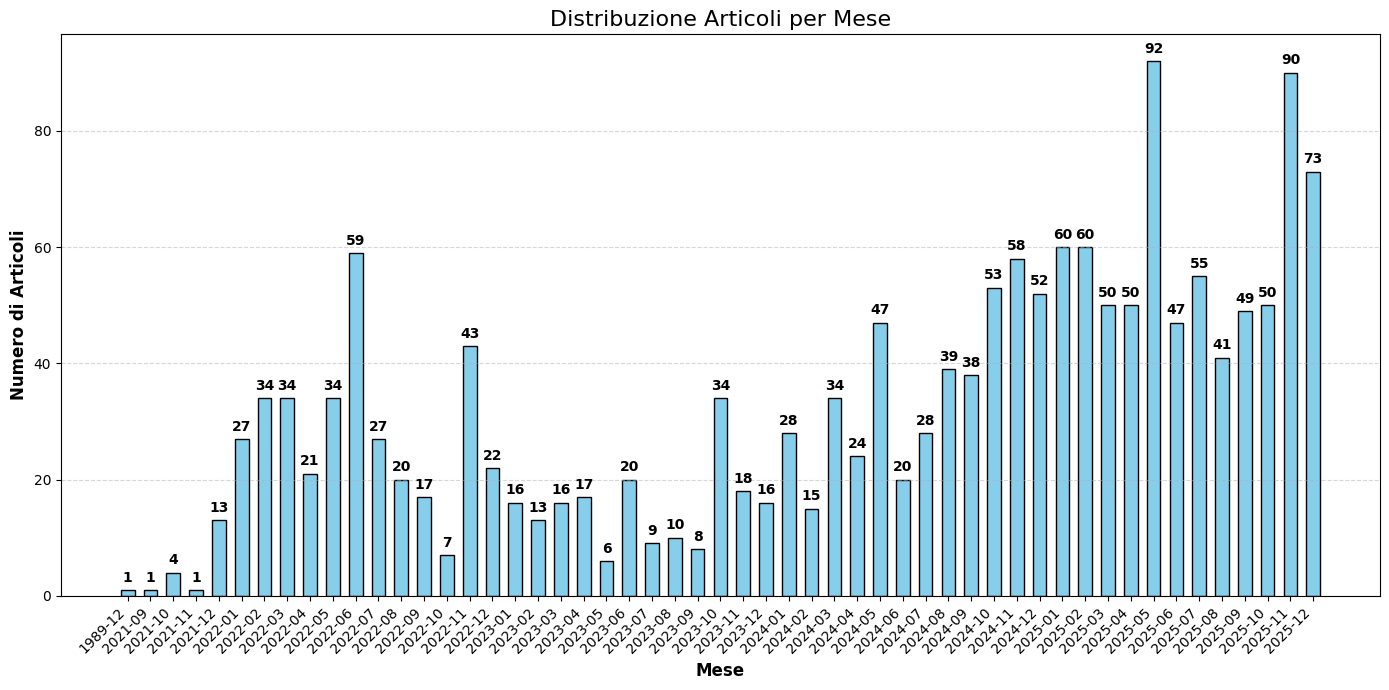

In [40]:
# 1. Connessione
client = MongoClient("mongodb://localhost:27017")
db = client['bitcoin_project']
collection = db['Article']

# 2. Recupero Dati (SEMPLIFICATO)
# Non serve più l'aggregazione complessa. 
# Chiediamo a Mongo solo il campo 'pub_date' di tutti i documenti.
projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato! Assicurati di aver popolato il DB con il nuovo script.")
else:
    # 3. Preparazione DataFrame
    df = pd.DataFrame(data)
    
    # Verifica che la colonna 'pub_date' esista (per sicurezza)
    if 'pub_date' not in df.columns:
        print("ERRORE: Il campo 'pub_date' non è stato trovato nei documenti.")
        print("Esempio di documento nel DB:", collection.find_one())
    else:
        # Conversione data
        df['data'] = pd.to_datetime(df['pub_date'], errors='coerce')
        
        # Rimuove eventuali date non valide (NaT)
        df = df.dropna(subset=['data'])

        # Raggruppa per mese
        df['mese_anno'] = df['data'].dt.to_period('M')
        conteggio_mensile = df['mese_anno'].value_counts().sort_index()

        # Preparazione dati per il grafico
        mesi = conteggio_mensile.index.strftime('%Y-%m') 
        conteggi = conteggio_mensile.values

        # 4. Generazione Grafico (Il tuo codice di plotting era già ottimo!)
        plt.figure(figsize=(14, 7)) 
        
        plt.bar(mesi, conteggi, color='skyblue', edgecolor='black', width=0.6)

        plt.xlabel('Mese', fontsize=12, fontweight='bold')
        plt.ylabel('Numero di Articoli', fontsize=12, fontweight='bold')
        plt.title('Distribuzione Articoli per Mese', fontsize=16)
        
        # Formattazione asse X
        plt.xticks(
            rotation=45, 
            ha='right', 
            fontsize=10 
        )
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Etichette sopra le barre
        for i, v in enumerate(conteggi):
            plt.text(i, v + (max(conteggi)*0.01), str(v), ha='center', va='bottom', fontweight='bold')

        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        plt.show()

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_28212\1577494681.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


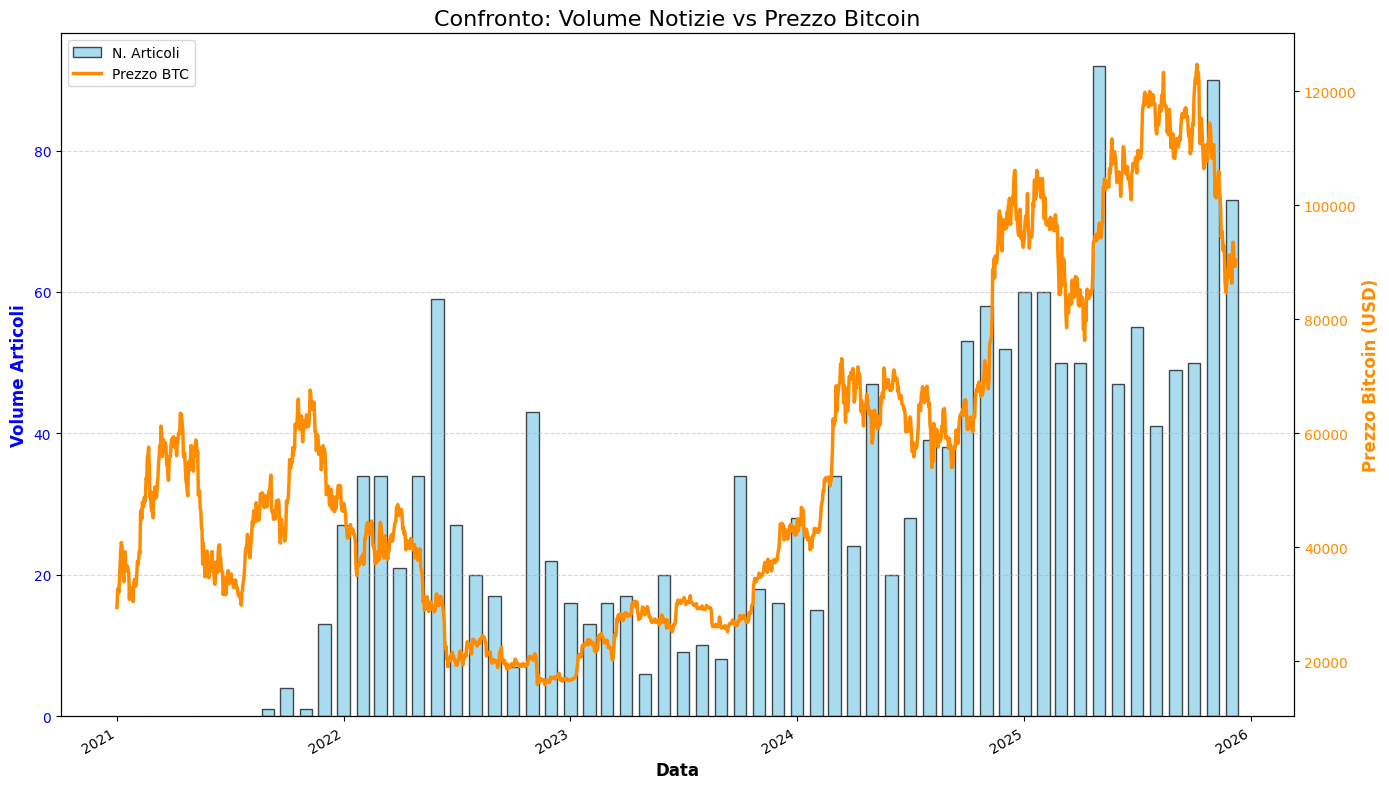

In [38]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2021-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['bitcoin_project']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2021-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzo, color=color_line, linewidth=2.5, label='Prezzo BTC')
            ax2.set_ylabel('Prezzo Bitcoin (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()

### Other news API:

In [14]:
key = os.getenv("NEWS_KEY")
url = ('https://newsapi.org/v2/everything?'
       'q=Bitcoin&'
       'from=2025-11-10&'
       'sortBy=popularity&'
       f'apiKey={key}')

In [15]:
news_resp = requests.get(url).json()
news_resp

{'status': 'ok',
 'totalResults': 14234,
 'articles': [{'source': {'id': 'wired', 'name': 'Wired'},
   'author': 'Joel Khalili',
   'title': 'Inside a Wild Bitcoin Heist: Five-Star Hotels, Cash-Stuffed Envelopes, and Vanishing Funds',
   'description': 'Sophisticated crypto scams are on the rise. But few of them go to the lengths one bitcoin mining executive experienced earlier this year.',
   'url': 'https://www.wired.com/story/bitcoin-scam-mining-as-service/',
   'urlToImage': 'https://media.wired.com/photos/6913b909f757bec53ccf7811/191:100/w_1280,c_limit/Bitcoin-Heist-Business-1304706668.jpg',
   'publishedAt': '2025-11-17T10:00:00Z',
   'content': 'As Kent Halliburton stood in a bathroom at the Rosewood Hotel in central Amsterdam, thousands of miles from home, running his fingers through an envelope filled with 10,000 in crisp banknotes, he sta… [+2362 chars]'},
  {'source': {'id': 'the-verge', 'name': 'The Verge'},
   'author': 'Nilay Patel',
   'title': 'Square’s product chief on

In [16]:
len(news_resp['articles'])

100

## CryptoPanic:

In [31]:
# --- CONFIGURAZIONE ---
API_KEY = os.getenv("PANIC_KEY")
MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "bitcoin_pr2"
COLL_NAME = "CryptoPanic_News" # Usiamo una collezione separata per ordine

# --- CONNESSIONE MONGO ---
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLL_NAME]

# --- CONFIGURAZIONE API ---
base_url = "https://cryptopanic.com/api/v1/posts/"
params = {
    "auth_token": API_KEY,
    "currencies": "BTC",    # Filtra solo Bitcoin
    "kind": "news",        # Solo notizie (esclude media/video)
    "public": "true"
}

print("Inizio scaricamento notizie da CryptoPanic...")

# Ciclo per scaricare più pagine
pagina_corrente = 1
max_pagine = 10  # Cambia questo numero se vuoi più dati

while base_url and pagina_corrente <= max_pagine:
    try:
        print(f"Scaricamento pagina {pagina_corrente}...")
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # Controlla se ci sono risultati
        if "results" in data:
            posts = data["results"]
            
            # Inserimento in MongoDB
            if posts:
                # Aggiungiamo un campo per riconoscere la fonte facilmente
                for post in posts:
                    post['source_type'] = 'cryptopanic_api'
                
                collection.insert_many(posts)
                print(f"✅ Inseriti {len(posts)} articoli nel DB.")
            else:
                print("Nessun articolo trovato in questa pagina.")
        
        # Gestione Paginazione
        # L'API ci dà il link per la pagina successiva nel campo 'next'
        base_url = data.get("next")
        params = {} # I parametri sono già inclusi nell'url 'next', svuotiamo params
        
        pagina_corrente += 1
        time.sleep(1) # Pausa di cortesia per non essere bloccati
        
    except Exception as e:
        print(f"Errore: {e}")
        break

print("Finito!")
client.close()

Inizio scaricamento notizie da CryptoPanic...
Scaricamento pagina 1...
✅ Inseriti 20 articoli nel DB.
Finito!
